# Réalisez une ACP - Les données Open Food Facts

# 1 Preliminary

## 1.1 Context


L'agence Santé publique France souhaite améliorer sa base de données Open Food Facts et fait appel aux services de votre entreprise. Cette base de données open source est mise à la disposition de particuliers et d’organisations afin de leur permettre de connaître la qualité nutritionnelle de produits. 

L'agence Santé publique France
 

Aujourd’hui, pour ajouter un produit à la base de données d'Open Food Facts, il est nécessaire de remplir de nombreux champs textuels et numériques, ce qui peut conduire à des erreurs de saisie et à des valeurs manquantes dans la base. 

L’agence Santé publique France confie à votre entreprise la création d’un système de suggestion ou d’auto-complétion pour aider les usagers à remplir plus efficacement la base de données. Dans un premier temps, vous devez vous concentrer sur la prise en main des données, et d’abord les nettoyer et les explorer. 

Vous êtes missionné sur le projet de nettoyage et exploration des données en interne, afin de déterminer la faisabilité de cette idée d’application de Santé publique France. 

<br>

------------------------------



<br>

* version : 0.0.1
* last update:  2023-06-23

<br>

## 1.2 Imports

Nous allons importer nos librairies :

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random
import pickle
from sklearn.linear_model import LinearRegression 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, validation_curve, GridSearchCV
from scipy import stats,spatial

In [86]:
df= pd.read_csv("../data/data_cleaned_and_without_outliners_Open_Foods.csv")



In [87]:
df.info

<bound method DataFrame.info of         nutriscore_score  energy-kcal_100g  energy_100g  fat_100g  \
0                   -5.0              57.0      40.4000       0.2   
1                   18.0             205.0       5.4000       8.2   
2                    9.0              63.0      25.2000       0.0   
3                    1.0              32.0      99.2000       0.3   
4                   14.0             381.0      28.0000      22.0   
...                  ...               ...          ...       ...   
718077               0.0             351.0      18.1034       0.5   
718078              15.0             333.0       9.4000      20.2   
718079              12.0             229.6      50.0000       7.6   
718080              -2.0             131.0      56.8800       5.0   
718081              -7.0             191.0       7.8000      11.0   

        saturated_fat_100g  carbohydrates_100g  sugars_100g  fiber_100g  \
0                      0.1        3.900000e+00          3.9    0

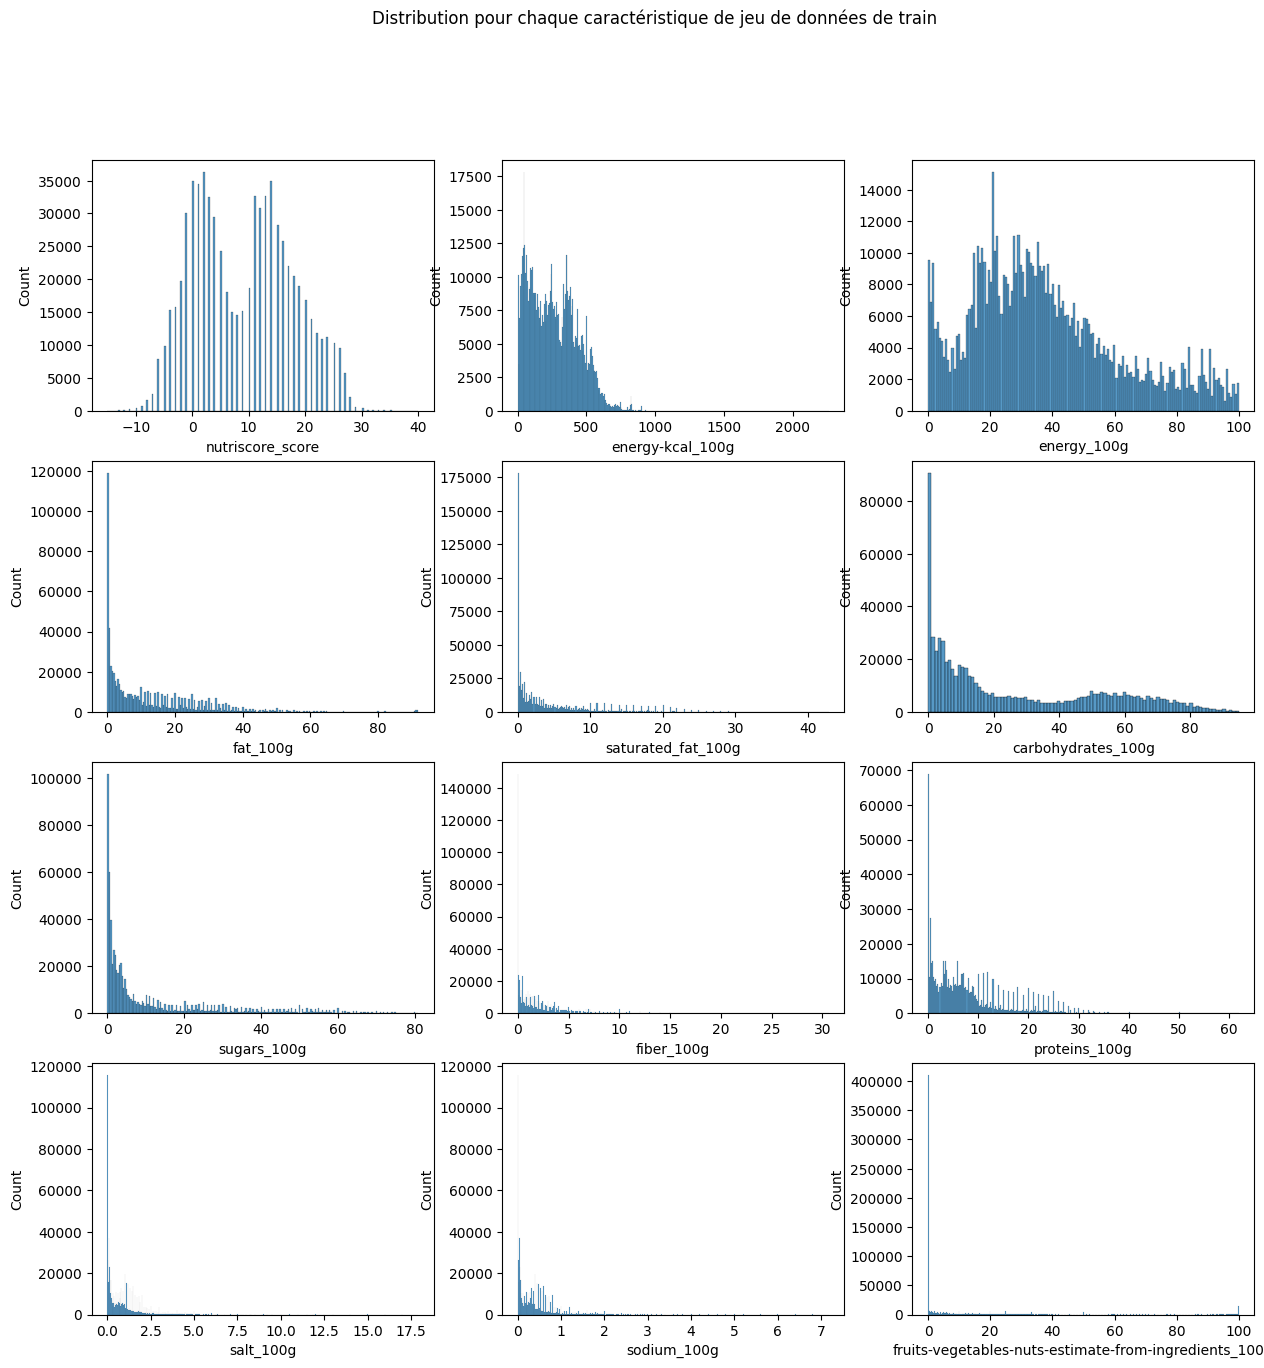

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt

# Exemple de données (remplacez ceci par vos propres données)
for i in range(df.shape[1]): 
    data = df[df.columns[i]]

# Créez une figure et des axes
fig, axs = plt.subplots(4, 3, figsize=(15, 15))
axs = axs.ravel()

# Parcourez les colonnes et tracez l'histogramme avec histplot
for i in range(df.shape[1]-2):
    sns.histplot(df[df.columns[i]], ax=axs[i])

# Ajoutez un titre global à la figure
fig.suptitle('Distribution pour chaque caractéristique de jeu de données de train')

# Affichez la figure
plt.show()


In [89]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Assuming you have a DataFrame named "df"
# Adjust the test_size and unknown_size as needed
test_size = 0.2
unknown_size = 0.1

# A random seed for reproducibility
random_seed = 42

# Splitting the DataFrame into train and temp (test + unknown) sets
train, temp_df = train_test_split(df, test_size=test_size + unknown_size, random_state=random_seed)

# Splitting the temp set into test and unknown sets
test, unknown_df = train_test_split(temp_df, test_size=unknown_size / (test_size + unknown_size), random_state=random_seed)

# Printing the shapes of each dataset
print("Train data shape:", train.shape)
print("Test data shape:", test.shape)
print("Unknown data shape:", unknown_df.shape)

Train data shape: (502657, 14)
Test data shape: (143616, 14)
Unknown data shape: (71809, 14)


In [90]:
train.drop(columns='mean',inplace=True)
train.drop(columns=['fruits-vegetables-nuts-estimate-from-ingredients_100g','nutrition_score_fr_100g','energy-kcal_100g'],inplace=True)


In [91]:
test.drop(columns='mean',inplace=True)
test.drop(columns=['fruits-vegetables-nuts-estimate-from-ingredients_100g','nutrition_score_fr_100g','energy-kcal_100g'],inplace=True)

In [92]:
unknown_df.drop(columns='mean',inplace=True)
unknown_df.drop(columns=['fruits-vegetables-nuts-estimate-from-ingredients_100g','nutrition_score_fr_100g','energy-kcal_100g'],inplace=True)

In [93]:
train.describe

<bound method NDFrame.describe of         nutriscore_score  energy_100g   fat_100g  saturated_fat_100g  \
687434              16.0      31.4000   9.000000            5.000000   
450151               4.0      13.0000   0.000000            0.000000   
361512              20.0      22.3000  23.100000           16.000000   
516004              22.0       4.2000  23.500000           12.100000   
236517              20.0      18.2000  48.000000           18.000000   
...                  ...          ...        ...                 ...   
259178               4.0      40.6000  15.000000            3.300000   
365838              14.0       0.7576  27.000000           19.000000   
131932              15.0      47.6600  23.333333            1.666667   
671155               3.0      21.0000   0.500000            0.100000   
121958              11.0      31.9194   9.800000            3.200000   

        carbohydrates_100g  sugars_100g  fiber_100g  proteins_100g  salt_100g  \
687434        6.9000

In [94]:
train.shape[1]

10

In [95]:
train[train.columns[0]]

687434    16.0
450151     4.0
361512    20.0
516004    22.0
236517    20.0
          ... 
259178     4.0
365838    14.0
131932    15.0
671155     3.0
121958    11.0
Name: nutriscore_score, Length: 502657, dtype: float64

## Coefficient de corrélation de Pearson

In [96]:
train.corr().reindex(['nutriscore_score'],axis=1)

,nutriscore_score
nutriscore_score,1.000000
energy_100g,-0.210751
fat_100g,0.551252
saturated_fat_100g,0.648406
carbohydrates_100g,0.237606
sugars_100g,0.447688
fiber_100g,-0.166487
proteins_100g,0.069394
salt_100g,0.255484
sodium_100g,0.256822


In [97]:
test_pear = pd.DataFrame(columns=['coef_pearson','p_value'])
for i in range(1,len(train.columns)):

    pear, pval = stats.pearsonr(train['nutriscore_score'], train[train.columns[i]])
    test_pear.loc[train.columns[i]]=[pear,pval]
    
test_pear  

,coef_pearson,p_value
energy_100g,-0.210751,0.0
fat_100g,0.551252,0.0
saturated_fat_100g,0.648406,0.0
carbohydrates_100g,0.237606,0.0
sugars_100g,0.447688,0.0
fiber_100g,-0.166487,0.0
proteins_100g,0.069394,0.0
salt_100g,0.255484,0.0
sodium_100g,0.256822,0.0


Nous pouvons observer une corrélation significative entre les caractéristiques suivantes:

- énergie (energy)
- graisses et graisses saturées (fat & saturated-fat )
- sucres (sugars)

<Axes: >

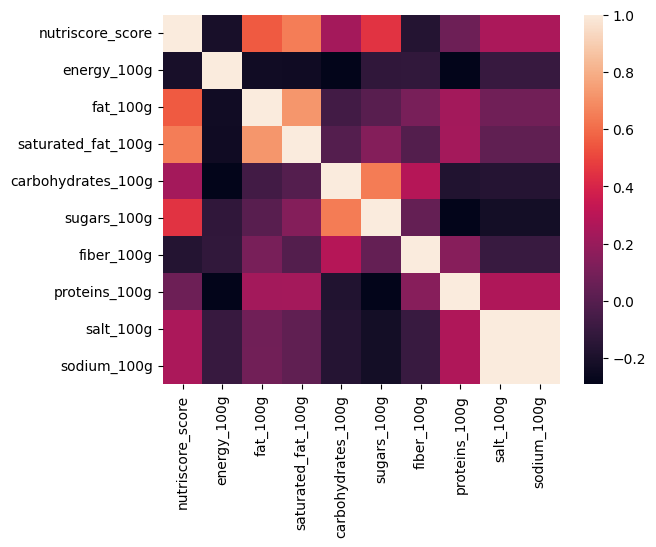

In [98]:
sns.heatmap(train.corr())

Nous pouvons observer une corrélation significative entre les caractéristiques suivantes:

- graisses / graisses saturées (fat/ saturated-fat)
- glucides / sucres (carbohydrates/ sugars)
- sel / sodium (salt/sodium)

## Test de normalité (Kolmogorov-Smirnov)

In [99]:
alpha= 0.05
print('===================\nnull hypothesis : studied feature follow a normal distribution.\n ===================\n\n')

for i in range(len(train.columns)): 
    
    D, pval = stats.kstest(train[train.columns[i]], 'norm')
    print('D= {}\nP-value= {}'.format(D,pval))
    if pval<alpha: 
        print('P-value is lower than alpha ({}) we can reject the null hypothesis\n => {} does not follow normal distribution'
              .format(alpha,train.columns[i]))
    else : 
        print('We cannot reject the null hypothesis')
    print('----------------\n')
    

null hypothesis : studied feature follow a normal distribution.


D= 0.7355522491984079
P-value= 0.0
P-value is lower than alpha (0.05) we can reject the null hypothesis
 => nutriscore_score does not follow normal distribution
----------------

D= 0.9541860358481659
P-value= 0.0
P-value is lower than alpha (0.05) we can reject the null hypothesis
 => energy_100g does not follow normal distribution
----------------

D= 0.676012642667513
P-value= 0.0
P-value is lower than alpha (0.05) we can reject the null hypothesis
 => fat_100g does not follow normal distribution
----------------

D= 0.5
P-value= 0.0
P-value is lower than alpha (0.05) we can reject the null hypothesis
 => saturated_fat_100g does not follow normal distribution
----------------

D= 0.8184417742622188
P-value= 0.0
P-value is lower than alpha (0.05) we can reject the null hypothesis
 => carbohydrates_100g does not follow normal distribution
----------------

D= 0.6255395989435719
P-value= 0.0
P-value is lower than alpha (

## Test ANOVA 

In [100]:
nutriscore_range = train['nutriscore_score'].max()-train['nutriscore_score'].min()
print('Gap in each bin :',nutriscore_range/5)

Gap in each bin : 11.0


In [101]:
starting_value = -15
# Gap rounded up 
gap = 11
bins=[]
for i in range(6):
    bins.append(starting_value+i*gap)
labels=['A','B','C','D','E']


train['NUTRI-SCORE'] = pd.cut(train['nutriscore_score'], bins=bins, labels=labels)
train.head()

,nutriscore_score,energy_100g,fat_100g,saturated_fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,NUTRI-SCORE
687434,16.0,31.4,9.0,5.0,69.0,48.0,3.10,4.4,0.27,0.108,C
450151,4.0,13.0,0.0,0.0,0.7,0.5,0.22,0.5,1.10,0.440,B
361512,20.0,22.3,23.1,16.0,55.7,2.7,3.40,12.8,1.80,0.720,D
516004,22.0,4.2,23.5,12.1,55.4,30.3,0.80,5.6,0.45,0.180,D
236517,20.0,18.2,48.0,18.0,1.5,1.3,0.26,8.6,1.30,0.520,D


In [102]:
cols = train.columns[1:-1].tolist()
cols  

['energy_100g',
 'fat_100g',
 'saturated_fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g']

In [103]:
F, p = stats.f_oneway(train.loc[train["NUTRI-SCORE"] == 'A',cols],
                      train.loc[train["NUTRI-SCORE"] == 'B',cols],
                      train.loc[train["NUTRI-SCORE"] == 'C',cols],
                      train.loc[train["NUTRI-SCORE"] == 'D',cols],
                      train.loc[train["NUTRI-SCORE"] == 'E',cols])

In [104]:
results_anova =pd.DataFrame(columns=['F','P_value'])
for i in range(len(cols)):
    results_anova.loc[cols[i]]=[F[i],p[i]]
results_anova   

,F,P_value
energy_100g,7233.882438,0.0
fat_100g,50779.652227,0.0
saturated_fat_100g,86782.798813,0.0
carbohydrates_100g,9270.426406,0.0
sugars_100g,28891.765529,0.0
fiber_100g,6394.788669,0.0
proteins_100g,1384.982978,0.0
salt_100g,9432.245698,0.0
sodium_100g,9473.467091,0.0


Results to be put into perspective, as our data does not follow a normal distribution 

<Axes: xlabel='sugars_100g', ylabel='NUTRI-SCORE'>

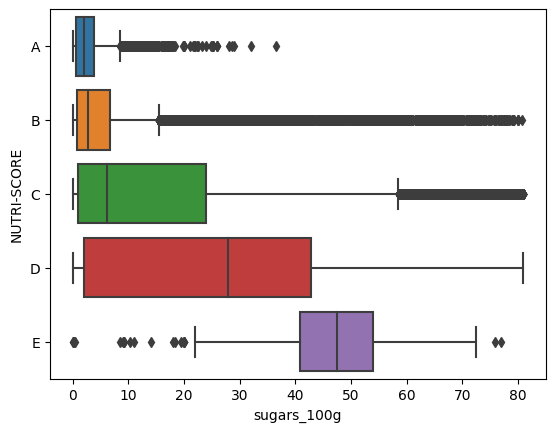

In [105]:
sns.boxplot(y='NUTRI-SCORE',x='sugars_100g',data=train)

## Analyse en composantes principales (ACP)

In [106]:
data_pca = train.copy()
data_pca.drop(columns=['nutriscore_score','NUTRI-SCORE'],inplace=True)
data_pca

,energy_100g,fat_100g,saturated_fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g
687434,31.4000,9.000000,5.000000,6.900000e+01,48.000000,3.100,4.4,0.270000,0.108000
450151,13.0000,0.000000,0.000000,7.000000e-01,0.500000,0.220,0.5,1.100000,0.440000
361512,22.3000,23.100000,16.000000,5.570000e+01,2.700000,3.400,12.8,1.800000,0.720000
516004,4.2000,23.500000,12.100000,5.540000e+01,30.300000,0.800,5.6,0.450000,0.180000
236517,18.2000,48.000000,18.000000,1.500000e+00,1.300000,0.260,8.6,1.300000,0.520000
...,...,...,...,...,...,...,...,...,...
259178,40.6000,15.000000,3.300000,3.552714e-15,0.000000,0.000,22.0,1.000000,0.400000
365838,0.7576,27.000000,19.000000,1.000000e+00,0.500000,1.800,20.0,1.200000,0.480000
131932,47.6600,23.333333,1.666667,2.666667e+01,26.666667,0.000,0.0,1.166667,0.466667
671155,21.0000,0.500000,0.100000,1.600000e+01,16.000000,0.132,0.5,0.160000,0.064000


In [22]:
to_standard = data_pca.values
to_standard
scaler= StandardScaler()
standard = scaler.fit_transform(to_standard)
standard

array([[-1.01849428,  2.68665522,  2.74161363, ...,  0.14421446,
         1.37063658,  1.37008383],
       [ 1.836252  , -0.8605305 , -0.73478163, ..., -0.99191868,
        -0.65633054, -0.65616054],
       [-0.2774392 ,  0.30594788, -0.73478163, ..., -0.81518686,
        -0.66993434, -0.66975949],
       ...,
       [-0.38691324, -0.8605305 , -0.73478163, ..., -1.01716608,
        -0.66993434, -0.66975949],
       [ 1.01940719, -0.38302473, -0.16591695, ..., -0.77731575,
        -0.60191531, -0.60176471],
       [ 1.80256768, -0.63542064, -0.33973671, ..., -0.71419725,
        -0.56110389, -0.56096785]])

In [23]:
pca = PCA()
data_pca = pca.fit_transform(standard)

Variance Ratio(%) :  [27.8 22.8 16.2 12.6  9.   5.8  3.   2.7  0. ]


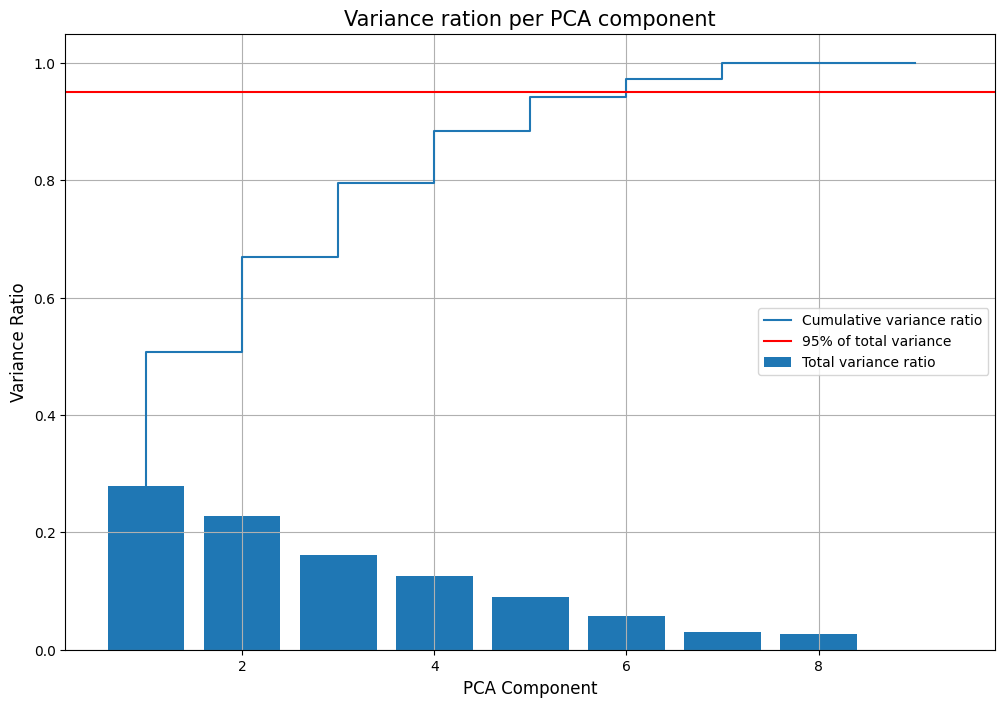

In [24]:
var_ratio = pca.explained_variance_ratio_
print('Variance Ratio(%) : ',np.around(var_ratio*100,1))
plt.figure(figsize=(12,8))
plt.bar(range(1,len(var_ratio)+1),var_ratio,align='center',label='Total variance ratio')
plt.step(range(1,len(var_ratio)+1),np.cumsum(var_ratio),label='Cumulative variance ratio')
plt.axhline(y=0.95,color='red',label='95% of total variance')
plt.xlabel('PCA Component',fontsize=12)
plt.ylabel('Variance Ratio',fontsize=12)
plt.legend(loc=7)
plt.title('Variance ration per PCA component',fontsize=15)
plt.grid()
plt.show()

Eigen Values :  [2.50503799e+00 2.05524489e+00 1.45850387e+00 1.13351969e+00
 8.06567247e-01 5.24310730e-01 2.73865502e-01 2.42942120e-01
 2.59045204e-05] 
-------------



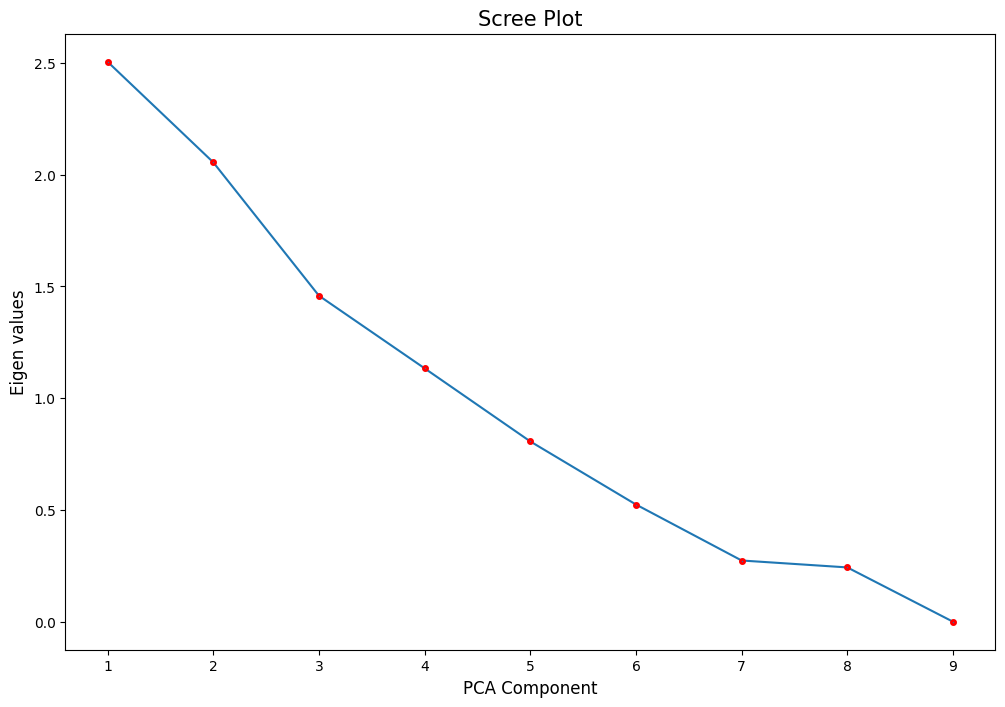

In [25]:
eigen_values = pca.explained_variance_
print('Eigen Values : ',eigen_values,'\n-------------\n')

plt.figure(figsize=(12,8))
plt.plot(range(1,len(eigen_values)+1),eigen_values,marker='.',mec='r',mew=2)
plt.title('Scree Plot',fontsize=15)
plt.ylabel("Eigen values",fontsize=12)
plt.xlabel("PCA Component",fontsize=12)
plt.show()


In [26]:
cols

['energy_100g',
 'fat_100g',
 'saturated_fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g']

[-0.11654905  0.22843126  0.17637186 -0.30358651 -0.33514707 -0.07253431
  0.3685501   0.52800899  0.52797369] 
 [-0.42282852  0.48481662  0.50602506  0.34303404  0.32519137  0.24368022
  0.18419886 -0.08176731 -0.08179599]


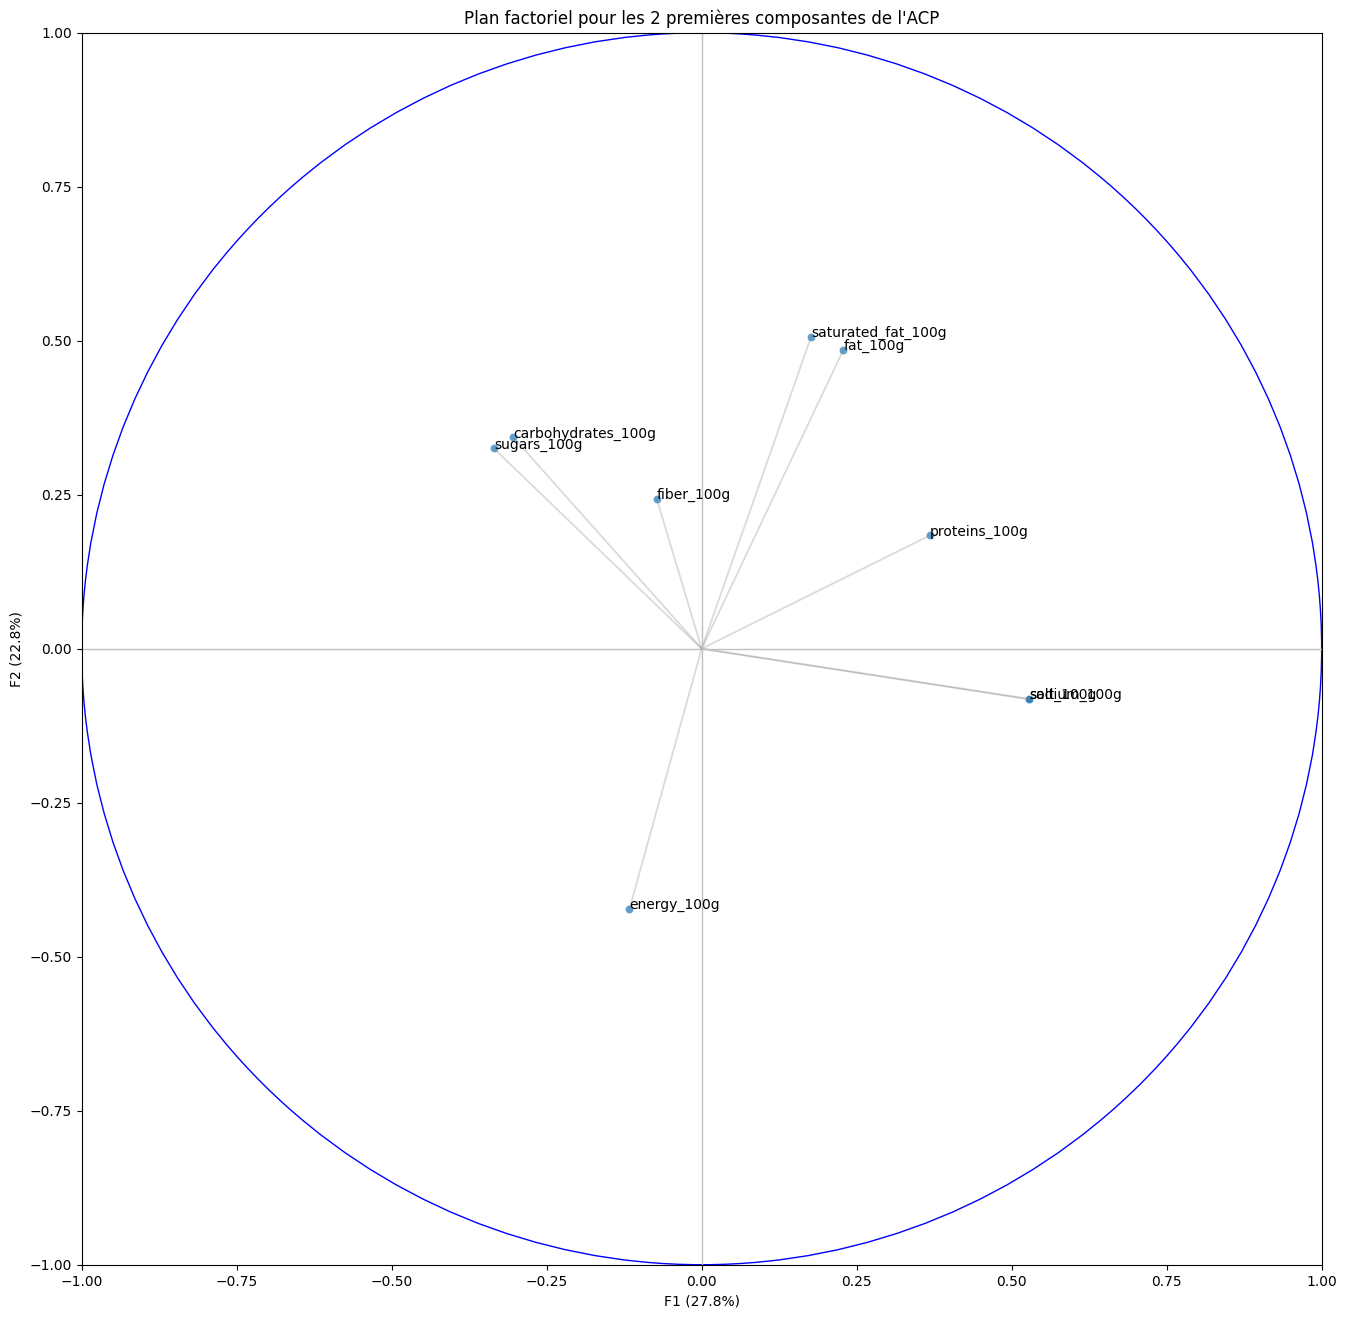

In [27]:
xpca =pca.components_[0,:]
ypca =pca.components_[1,:]

print(pca.components_[0,:],'\n',pca.components_[1,:])
fig, axes = plt.subplots(figsize=(16,16))

plt.title("Plan factoriel pour les 2 premières composantes de l'ACP")
plt.xlabel('F1 ({}%)'.format(np.around(var_ratio[0]*100,1)))
plt.ylabel('F2 ({}%)'.format(np.around(var_ratio[1]*100,1)))

axes.set_xlim(-1,1)
axes.set_ylim(-1,1)
cercle = plt.Circle((0,0),1,color='blue',fill=False)
axes.add_artist(cercle)

plt.plot([-1,1],[0,0],color='silver',linestyle='-',linewidth=1)
plt.plot([0,0],[-1,1],color='silver',linestyle='-',linewidth=1)

sns.scatterplot(x= xpca, y= ypca ,alpha = 0.7)

for i in range(len(cols)):
    plt.annotate(cols[i], (xpca[i],ypca[i]))
    axes.arrow(0, 0, xpca[i], ypca[i], head_width=0, head_length=0, fc='grey', ec='grey',alpha=0.2)

[-0.21248553 -0.32753366 -0.31842773  0.50866137  0.35371442  0.1198569
 -0.1183636   0.40859424  0.40865661] 
 [-0.20169509 -0.18513637 -0.31595227  0.01843883 -0.34907536  0.67845336
  0.44814018 -0.14471661 -0.14475047]


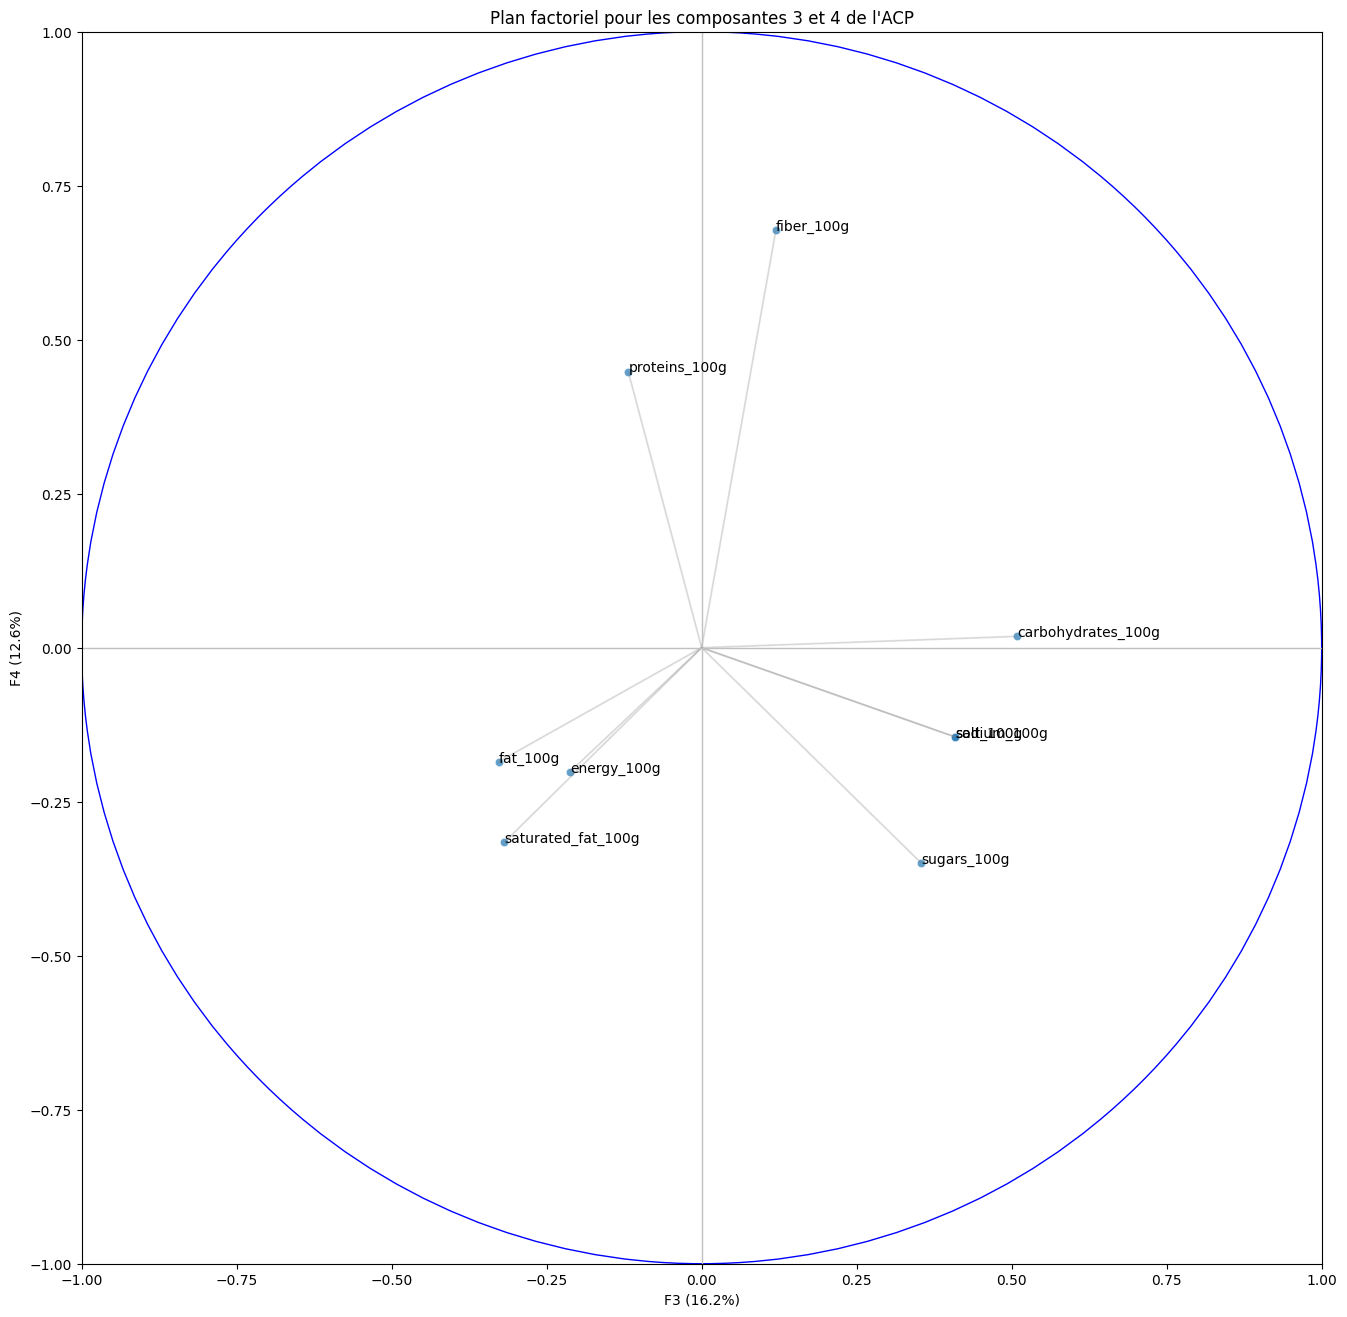

In [28]:
xpca =pca.components_[2,:]
ypca =pca.components_[3,:]

print(pca.components_[2,:],'\n',pca.components_[3,:])
fig, axes = plt.subplots(figsize=(16,16))

plt.title("Plan factoriel pour les composantes 3 et 4 de l'ACP")
plt.xlabel('F3 ({}%)'.format(np.around(var_ratio[2]*100,1)))
plt.ylabel('F4 ({}%)'.format(np.around(var_ratio[3]*100,1)))

axes.set_xlim(-1,1)
axes.set_ylim(-1,1)
cercle = plt.Circle((0,0),1,color='blue',fill=False)
axes.add_artist(cercle)

plt.plot([-1,1],[0,0],color='silver',linestyle='-',linewidth=1)
plt.plot([0,0],[-1,1],color='silver',linestyle='-',linewidth=1)

sns.scatterplot(x= xpca, y= ypca ,alpha = 0.7)

for i in range(len(cols)):
    plt.annotate(cols[i], (xpca[i],ypca[i]))
    axes.arrow(0, 0, xpca[i], ypca[i], head_width=0, head_length=0, fc='grey', ec='grey',alpha=0.2)

Que ce soit pour les composantes 1, 2, 3 ou 4 (en tout 85% de l'inertie totale des composantes), on observe des corrélations fortes entre certaines features :

- Sodium & salt (+++)
- Fat & Saturated Fat (++) 
- Carbohydrates & sugars (+)

In [29]:
data_pca2 = train.copy()
data_pca2.drop(columns=['nutriscore_score','binned',],inplace=True)
data_pca2.drop(columns=['carbohydrates_100g','saturated_fat_100g','sodium_100g'],inplace=True)
data_pca2

,energy_100g,fat_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g
457456,13.4000,52.00,0.70,0.00,9.20,3.00
588347,81.2000,0.00,10.90,0.20,0.20,0.02
217864,31.0000,17.10,0.00,0.00,1.60,0.00
528299,17.7062,1.30,3.00,2.40,10.30,0.03
553775,22.0000,5.00,18.00,9.00,8.33,1.15
...,...,...,...,...,...,...
259178,28.4000,29.00,0.00,0.34,16.00,1.00
365838,69.6800,3.69,0.00,0.10,19.50,0.14
131932,28.4000,0.00,69.78,0.00,0.00,0.00
671155,61.8000,7.00,28.00,1.86,1.90,0.10


In [30]:
cols = data_pca2.columns.tolist()
cols  

['energy_100g',
 'fat_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g']

In [31]:
to_standard2 = data_pca2.values
to_standard2
scaler2= StandardScaler()
standard2 = scaler.fit_transform(to_standard2)
standard2

array([[-1.01849428,  2.68665522, -0.68004371, -0.71688228,  0.14421446,
         1.37063658],
       [ 1.836252  , -0.8605305 , -0.08930706, -0.64688273, -0.99191868,
        -0.65633054],
       [-0.2774392 ,  0.30594788, -0.72058446, -0.71688228, -0.81518686,
        -0.66993434],
       ...,
       [-0.38691324, -0.8605305 ,  3.32074917, -0.71688228, -1.01716608,
        -0.66993434],
       [ 1.01940719, -0.38302473,  0.90104554, -0.06588648, -0.77731575,
        -0.60191531],
       [ 1.80256768, -0.63542064,  1.71186055, -0.50688363, -0.71419725,
        -0.56110389]])

In [32]:
pca2 = PCA()
data_pca2 = pca2.fit_transform(standard2)

Variance Ratio(%) :  [27.8 22.8 16.2 12.6  9.   5.8  3.   2.7  0. ]


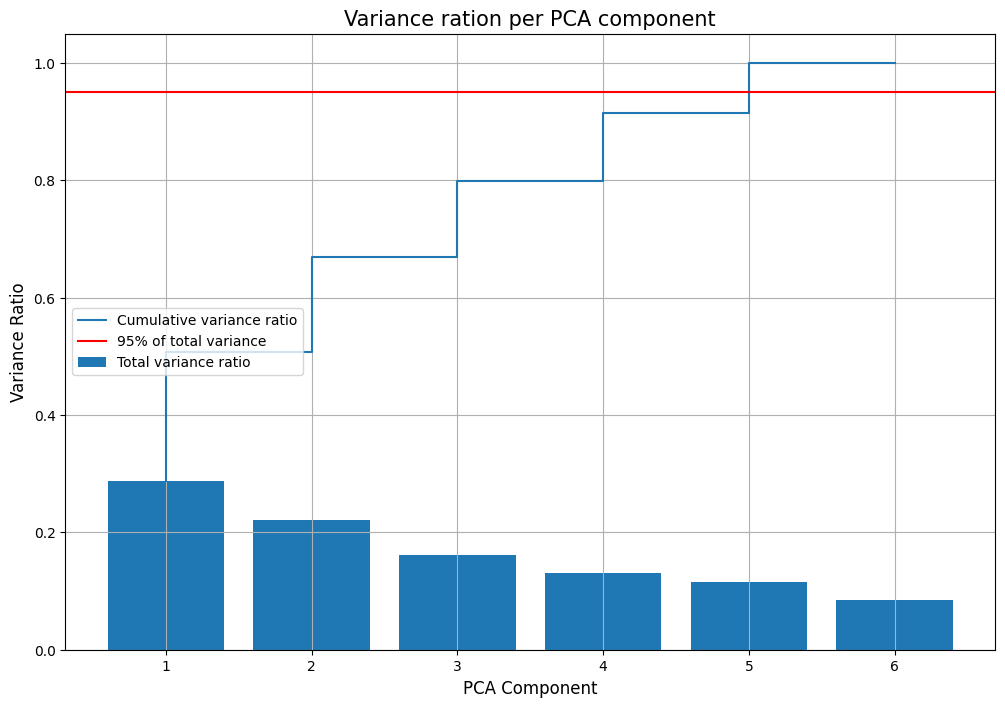

In [33]:
var_ratio2 = pca2.explained_variance_ratio_
print('Variance Ratio(%) : ',np.around(var_ratio*100,1))
plt.figure(figsize=(12,8))
plt.bar(range(1,len(var_ratio2)+1),var_ratio2,align='center',label='Total variance ratio')
plt.step(range(1,len(var_ratio2)+1),np.cumsum(var_ratio2),label='Cumulative variance ratio')
plt.axhline(y=0.95,color='red',label='95% of total variance')
plt.xlabel('PCA Component',fontsize=12)
plt.ylabel('Variance Ratio',fontsize=12)
plt.legend(loc=6)
plt.title('Variance ration per PCA component',fontsize=15)
plt.grid()
plt.show()

Six Values :  [1.72495451 1.32206835 0.96691755 0.78173933 0.69463356 0.50969866] 
-------------



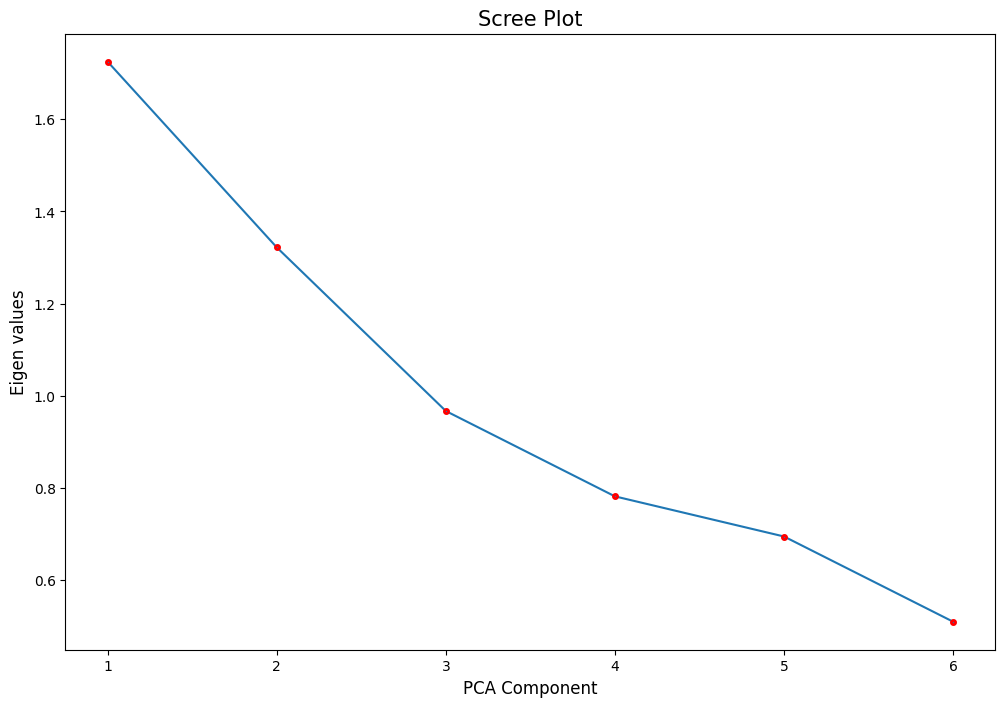

In [34]:
six_values = pca2.explained_variance_
print('Six Values : ',six_values,'\n-------------\n')

plt.figure(figsize=(12,8))
plt.plot(range(1,len(six_values)+1),six_values,marker='.',mec='r',mew=2)
plt.title('Scree Plot',fontsize=15)
plt.ylabel("Eigen values",fontsize=12)
plt.xlabel("PCA Component",fontsize=12)
plt.show()

In [35]:
pca2

PCA()

[-0.42813015  0.42061819 -0.27749633  0.19324768  0.60812852  0.39448161] 
 [ 0.41779711 -0.30472169 -0.60565382 -0.42779997  0.09393794  0.41705702]


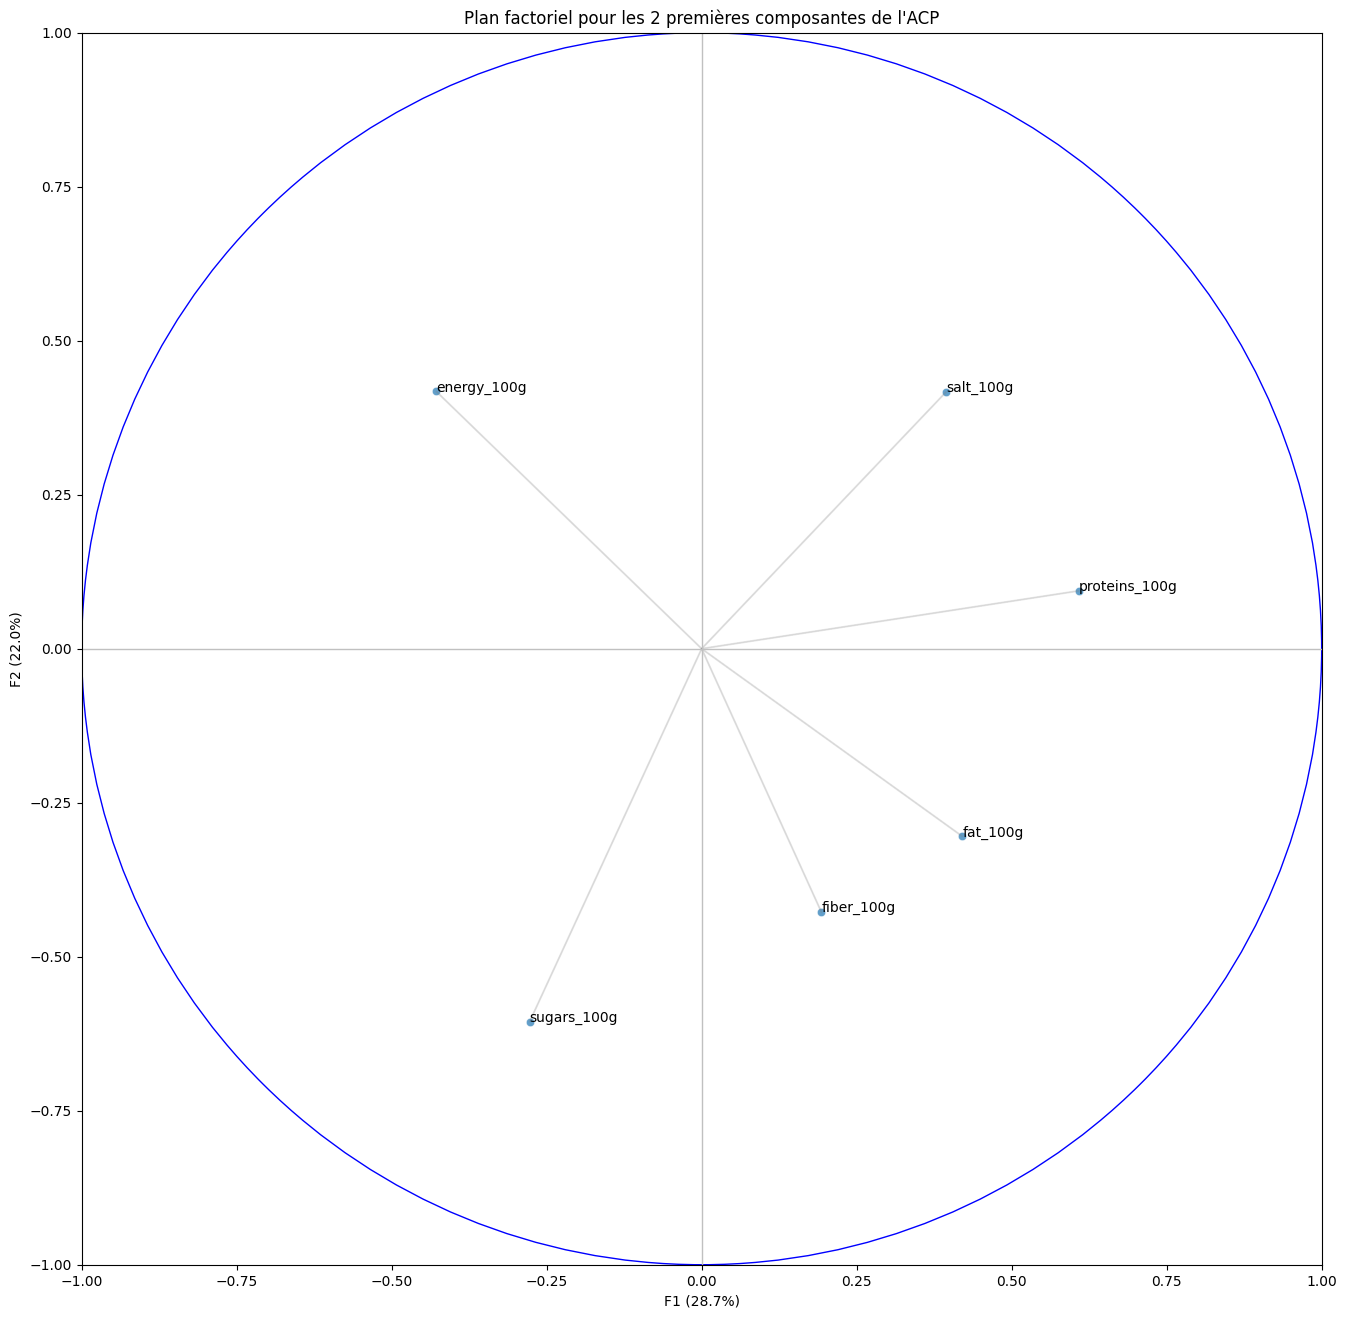

In [36]:
xpca2 =pca2.components_[0,:]
ypca2 =pca2.components_[1,:]

print(pca2.components_[0,:],'\n',pca2.components_[1,:])
fig, axes = plt.subplots(figsize=(16,16))

plt.title("Plan factoriel pour les 2 premières composantes de l'ACP")
plt.xlabel('F1 ({}%)'.format(np.around(var_ratio2[0]*100,1)))
plt.ylabel('F2 ({}%)'.format(np.around(var_ratio2[1]*100,1)))

axes.set_xlim(-1,1)
axes.set_ylim(-1,1)
cercle = plt.Circle((0,0),1,color='blue',fill=False)
axes.add_artist(cercle)

plt.plot([-1,1],[0,0],color='silver',linestyle='-',linewidth=1)
plt.plot([0,0],[-1,1],color='silver',linestyle='-',linewidth=1)

sns.scatterplot(x= xpca2, y= ypca2 ,alpha = 0.7)

for i in range(len(cols)):
    plt.annotate(cols[i], (xpca2[i],ypca2[i]))
    axes.arrow(0, 0, xpca2[i], ypca2[i], head_width=0, head_length=0, fc='grey', ec='grey',alpha=0.2)

[-0.21248553 -0.32753366 -0.31842773  0.50866137  0.35371442  0.1198569
 -0.1183636   0.40859424  0.40865661] 
 [-0.20169509 -0.18513637 -0.31595227  0.01843883 -0.34907536  0.67845336
  0.44814018 -0.14471661 -0.14475047]


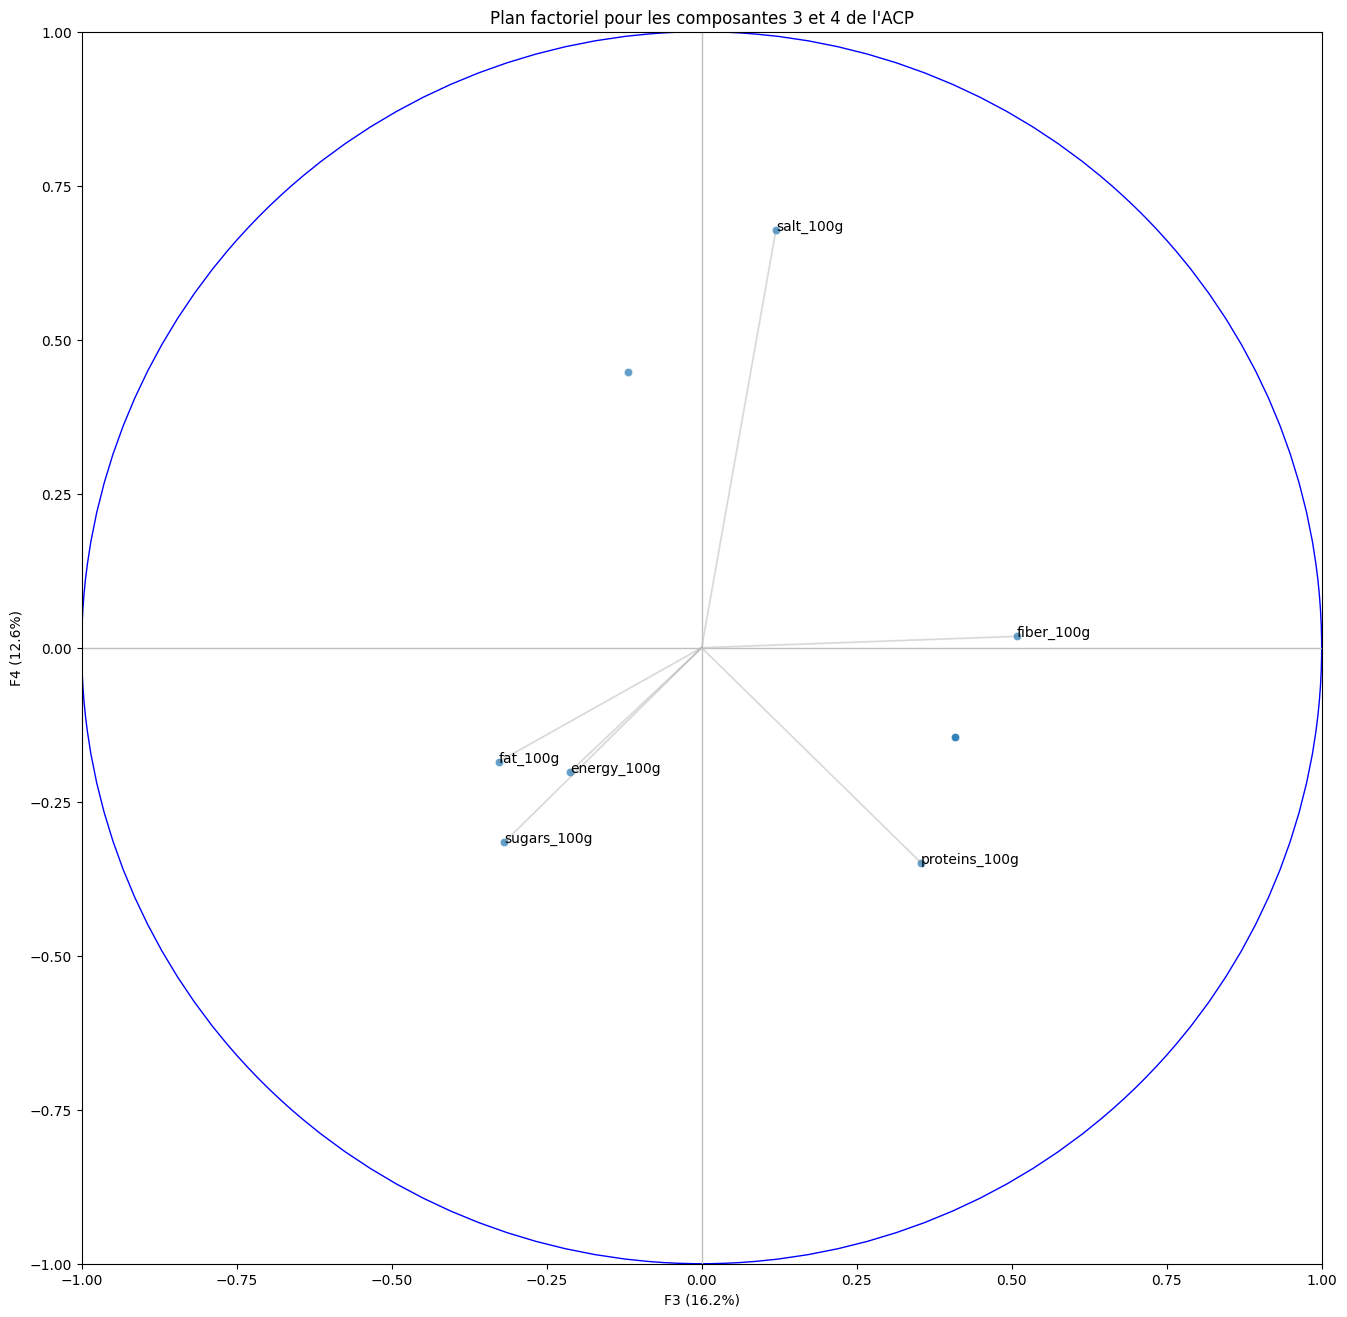

In [37]:
xpca =pca.components_[2,:]
ypca =pca.components_[3,:]

print(pca.components_[2,:],'\n',pca.components_[3,:])
fig, axes = plt.subplots(figsize=(16,16))

plt.title("Plan factoriel pour les composantes 3 et 4 de l'ACP")
plt.xlabel('F3 ({}%)'.format(np.around(var_ratio[2]*100,1)))
plt.ylabel('F4 ({}%)'.format(np.around(var_ratio[3]*100,1)))

axes.set_xlim(-1,1)
axes.set_ylim(-1,1)
cercle = plt.Circle((0,0),1,color='blue',fill=False)
axes.add_artist(cercle)

plt.plot([-1,1],[0,0],color='silver',linestyle='-',linewidth=1)
plt.plot([0,0],[-1,1],color='silver',linestyle='-',linewidth=1)

sns.scatterplot(x= xpca, y= ypca ,alpha = 0.7)

for i in range(len(cols)):
    plt.annotate(cols[i], (xpca[i],ypca[i]))
    axes.arrow(0, 0, xpca[i], ypca[i], head_width=0, head_length=0, fc='grey', ec='grey',alpha=0.2)

# Analyse Prédictive

## Linear regressor

In [40]:
scaler = StandardScaler()

X= train.drop(columns=['nutriscore_score'])
X = scaler.fit_transform(X)

y= train['nutriscore_score'].values
y = y.reshape(train.shape[0], 1)

Xtest= test.drop(columns=['nutriscore_score'])
Xtest = scaler.transform(Xtest)
ytest= test['nutriscore_score'].values
ytest = ytest.reshape(test.shape[0], 1)


linear_model = LinearRegression()
linear_model.fit(X,y)

print('Score de la prédiction (R²): ',linear_model.score(Xtest,ytest))

predict = linear_model.predict(Xtest)




Score de la prédiction (R²) sur train:  0.7276316050371749
Score de la prédiction (R²):  0.7281434361203762


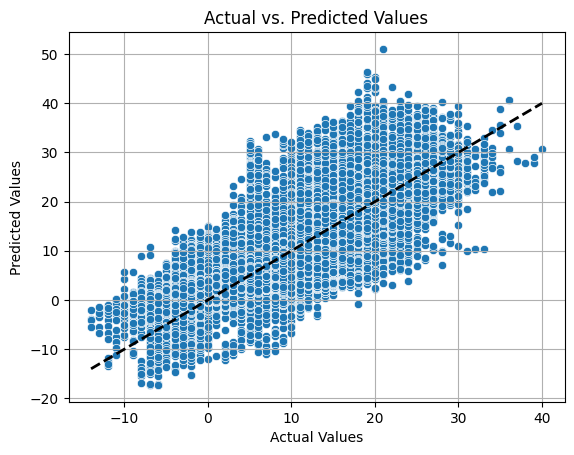

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame from your actual and predicted values
import pandas as pd
df = pd.DataFrame({'Actual Values': ytest.flatten(), 'Predicted Values': predict.flatten()})

# Create a scatter plot using Seaborn
sns.scatterplot(x='Actual Values', y='Predicted Values', data=df)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.grid(True)

# Add a diagonal line for reference (perfect prediction)
plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], 'k--', lw=2)
plt.show()


In [42]:
predict=pd.DataFrame(data=predict)
predict['nutriscore']=test['nutriscore_score']
predict.describe()

,0,nutriscore
count,143305.000000,28443.000000
mean,9.050775,9.130718
std,7.347869,8.540752
min,-17.281892,-14.000000
25%,3.278872,2.000000
50%,6.973002,10.000000
75%,13.821724,16.000000
max,51.050596,40.000000


In [43]:
print('Poids de chaque variable dans la régression:')
linear_coefs = pd.DataFrame(columns=['Feature','Coef'])
linear_coefs['Feature']=test.columns[1:]
linear_coefs['Coef']=linear_model.coef_[0]
linear_coefs

Poids de chaque variable dans la régression:


,Feature,Coef
0,energy_100g,0.385105
1,fat_100g,2.594847
2,saturated_fat_100g,3.213489
3,carbohydrates_100g,1.116639
4,sugars_100g,3.427246
5,fiber_100g,-1.858030
6,proteins_100g,0.078296
7,salt_100g,8.785529
8,sodium_100g,-6.112387


## KNN Regressor

### Test cross validation

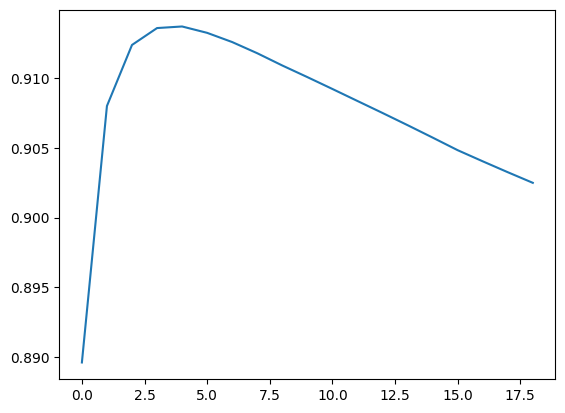

In [44]:
xtrain = train.drop(columns=['nutriscore_score'])
ytrain = train['nutriscore_score']

val_score = []
for i in range(1,20):
    score = cross_val_score(KNeighborsRegressor(i),xtrain,ytrain,cv=5).mean()
    val_score.append(score)
plt.plot(val_score)

First overview of crossvalidation function for KNN Regressor (1 Neighbor to 20) 

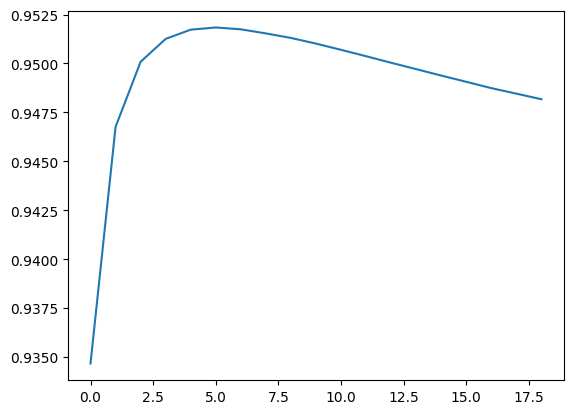

In [45]:
scaler = StandardScaler()

xtrain = scaler.fit_transform(train.drop(columns=['nutriscore_score']))
ytrain = train['nutriscore_score']

val_score = []
for i in range(1,20):
    score = cross_val_score(KNeighborsRegressor(i),xtrain,ytrain,cv=5).mean()
    val_score.append(score)
plt.plot(val_score)

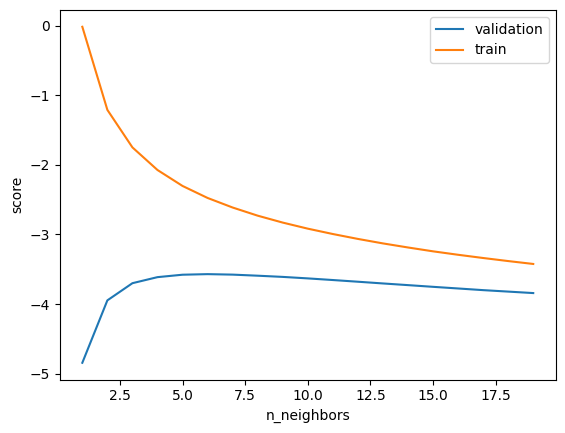

In [46]:
from sklearn.model_selection import validation_curve
import numpy as np
from sklearn.neighbors import KNeighborsRegressor

# Créez un modèle KNeighborsRegressor
model = KNeighborsRegressor()

# Plage de valeurs pour le paramètre n_neighbors (1 à 20)
param_range = np.arange(1, 20)

# Utilisez la fonction validation_curve pour évaluer le modèle pour différentes valeurs de n_neighbors
train_score2, val_score2 = validation_curve(
    model,           # Votre modèle (KNeighborsRegressor) ici
    xtrain,          # Vos données d'entraînement (xtrain)
    ytrain,          # Vos étiquettes d'entraînement (ytrain)
    param_name='n_neighbors',  # Nom du paramètre à ajuster (n_neighbors)
    param_range=param_range,    # Plage de valeurs à tester (1 à 20)
    cv=5,             # Nombre de plis de validation croisée (par exemple, 5)
    scoring='neg_mean_squared_error'  # Métrique de performance à utiliser (par exemple, erreur quadratique moyenne négative)
)

# train_scores et val_scores contiennent maintenant les performances du modèle pour différentes valeurs de n_neighbors

plt.plot(param_range, val_score2.mean(axis=1),label='validation')
plt.plot(param_range, train_score2.mean(axis=1),label='train')

plt.ylabel('score')
plt.xlabel('n_neighbors')
plt.legend()

Si les courbes de validation et d'entraînement se rapprochent l'une de l'autre et sont élevées, c'est généralement un bon signe, ce qui signifie que le modèle est capable de bien généraliser. Assurez-vous d'adapter les paramètres de votre modèle en fonction de ces résultats pour obtenir de bonnes performances de prédiction.

In [47]:
np.array(val_score)

array([0.93466535, 0.94675944, 0.95008657, 0.95125731, 0.95172768,
       0.95183993, 0.95174608, 0.95153681, 0.95130512, 0.95101575,
       0.95069811, 0.95037058, 0.95003608, 0.94971131, 0.94938197,
       0.94906252, 0.94874014, 0.9484571 , 0.9481716 ])

In [109]:
test.columns

Index(['nutriscore_score', 'energy_100g', 'fat_100g', 'saturated_fat_100g',
       'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
       'salt_100g', 'sodium_100g'],
      dtype='object')

In [107]:
nbneigh = np.array(val_score)
best=np.where(nbneigh== nbneigh.max())

print("Best Neighbors number: ", np.argmax(nbneigh), "\nBest neighbors accuracy result : ", nbneigh.max()*100,"%")

Best Neighbors number:  5 
Best neighbors accuracy result :  95.1839925718158 %


### KNeighborsRegressor optimisé avec GridSearchCV pour toutes les features

In [49]:
scaler = StandardScaler()

xtrain = scaler.fit_transform(train.drop(columns=['nutriscore_score']))
ytrain = train['nutriscore_score']

param_grid = {'n_neighbors':np.arange(1,20)}
scoring = ['r2','neg_mean_absolute_error','neg_mean_squared_error']

for i in range(len(scoring)):
    
    grid= GridSearchCV(KNeighborsRegressor(),param_grid,cv=5,scoring=scoring[i])
    grid.fit(xtrain,ytrain)
    
    print('Methode de Scoring: ',scoring[i])
    print('Meilleur score :',grid.best_score_)
    print('Meilleurs Paramètres :',grid.best_params_,'\n__________________')
    
    if i == 0 : 
        model_1 = grid.best_estimator_
    elif i == 1 : 
        model_2 = grid.best_estimator_
    else:
        model_3 = grid.best_estimator_



Methode de Scoring:  r2
Meilleur score : 0.9518399257181581
Meilleurs Paramètres : {'n_neighbors': 6} 
__________________
Methode de Scoring:  neg_mean_absolute_error
Meilleur score : -0.9726516970441246
Meilleurs Paramètres : {'n_neighbors': 1} 
__________________
Methode de Scoring:  neg_mean_squared_error
Meilleur score : -3.5706773312995814
Meilleurs Paramètres : {'n_neighbors': 6} 
__________________


### Prédiction du test 

In [50]:
xtest = scaler.transform(test.drop(columns=['nutriscore_score']))
ytest = test['nutriscore_score']
predict = model_1.predict(xtest)
print('Score estimé sur les données de test: ', np.around(model_1.score(xtest,ytest),2),'%')


Score estimé sur les données de test:  0.95 %


In [59]:

xunknown = scaler.transform(unknown_df.drop(columns=['nutriscore_score']))
yunknown = unknown_df['nutriscore_score']
predict = model_1.predict(xunknown)
print('Score estimé sur les données unknown : ', np.around(model_1.score(xunknown,yunknown),2),'%')


Score estimé sur les données unknown :  0.95 %


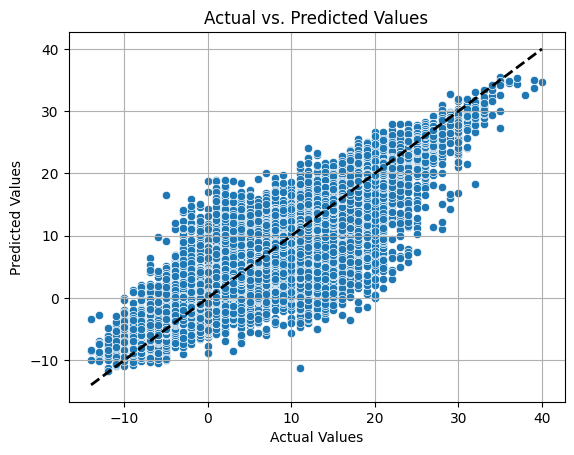

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Create a DataFrame from your actual and predicted values
df = pd.DataFrame({'Actual Values': ytest.ravel(), 'Predicted Values': predict.ravel()})

# Create a scatter plot using Seaborn
sns.scatterplot(x='Actual Values', y='Predicted Values', data=df)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.grid(True)

# Add a diagonal line for reference (perfect prediction)
plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], 'k--', lw=2)
plt.show()


In [52]:
test_predict=model_1.predict(xtest)
test_predict=pd.DataFrame(data=test_predict,columns=['Predict'])
test_predict['nutriscore']=test['nutriscore_score'].values
test_predict.describe()


,Predict,nutriscore
count,143305.000000,143305.000000
mean,8.998350,9.050333
std,8.459513,8.624177
min,-11.833333,-14.000000
25%,1.833333,2.000000
50%,9.000000,9.000000
75%,15.333333,16.000000
max,35.500000,40.000000


In [53]:
xtest = scaler.transform(test.drop(columns=['nutriscore_score']))
ytest = test['nutriscore_score']
predict = model_2.predict(xtest)
print('Score estimé sur les données de test: ', np.around(model_2.score(xtest,ytest),2),'%')


Score estimé sur les données de test:  0.94 %


In [54]:
xtest = scaler.transform(test.drop(columns=['nutriscore_score']))
ytest = test['nutriscore_score']
predict = model_3.predict(xtest)
print('Score estimé sur les données de test: ', np.around(model_3.score(xtest,ytest),2),'%')


Score estimé sur les données de test:  0.95 %
